# Basic RBM gammapy analysis for VERITAS data

Versions: gammapy (1.1), V2DL3 (0.5)

Source: Crab

Dataset: 64080,64081,64082,64083

In [1]:
import sys
import numpy as np
import yaml
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from gammapy.data import DataStore
from astropy import units as u

from gammapy_tools.templates import get_config
from gammapy_tools.make_background import *
import gammapy_tools.make_background as bkg
from gammapy_tools.analysis import make_spectrum_RE, get_flux_lc, rbm_analysis, rbm_plots, write_validation_info

import warnings
warnings.filterwarnings("ignore")

## Load in the config file

In [2]:
# with open('example_config.yaml', 'r') as file:
#     config = yaml.safe_load(file)

config = get_config()

In [3]:
# Modify the paths to various data stores

config['io']["search_datastore"] = "/raid/RAID1/VERITAS_Data/Background/MegaStore/moderate2tel_runwise"
config['io']['in_dir'] = "/raid/RAID1/VERITAS_Data/gammapy/Crab_Analysis/"
config['io']['out_dir'] = "/raid/RAID1/VERITAS_Data/gammapy/Crab_Analysis/"
config['io']['results_dir'] = "/raid/RAID1/VERITAS_Data/gammapy/Crab_Analysis/"

# Other option
# config['io']['from_run'] = True
config['background_selection']['smooth'] = True
config['background_selection']['smooth_sigma'] = 1.0

# Whether or not to use KL divergence to search for runs
config['background_selection']['KL_DIV'] = False

# Number of parallel jobs
config['config']['njobs'] = 10

In [4]:
config

{'io': {'search_datastore': '/raid/RAID1/VERITAS_Data/Background/MegaStore/moderate2tel_runwise',
  'in_dir': '/raid/RAID1/VERITAS_Data/gammapy/Crab_Analysis/',
  'out_dir': '/raid/RAID1/VERITAS_Data/gammapy/Crab_Analysis/',
  'results_dir': '/raid/RAID1/VERITAS_Data/gammapy/Crab_Analysis/',
  'from_run': False,
  'use_runlist': False},
 'binning': {'e_min': 0.1,
  'e_max': 100,
  'e_bins': 20,
  'off_min': 0,
  'off_max': 2.5,
  'off_bins': 5},
 'config': {'njobs': 10},
 'exclusion': {'star_cat': './Hipparcos_MAG8_1997.dat',
  'exclude_source_name': [['MGRO J1908+06', '0.5 deg']],
  'exclude_regions': [['287.10', '6.39', '0.5']]},
 'background_selection': {'nsb_diff': 0.7,
  'el_diff': 0.15,
  'az_diff': 45,
  'n_tels': 4,
  'time_max': 180,
  'time_request': 10,
  'smooth': True,
  'smooth_sigma': 1.0,
  'KL_DIV': False},
 'run_selection': {'runlist': [64080, 64081, 64082, 64083],
  'use_name': False,
  'source_name': 'Crab',
  'source_ra': 83.6333,
  'source_dec': 22.0133,
  'offset

# Prepare the dataset

Preparing a dataset involves setting up a datastore for the dataset you want to analyze. If you already have a datastore set up you can skip this step.

In [5]:
config = prepare_dataset(config)

Written to /raid/RAID1/VERITAS_Data/gammapy/Crab_Analysis//config.yaml


## Load in our data runs

Our DL3 files are contained in the config file in `config['io']['in_dir']`- let's load those in and look at our runlist

Alternatively, if you have preprocessed anasum files on disk, you can set `config['io']['in_dir']` to your datastore and set `config['io']['use_runlist']` = True as well as providing a runlist (same as ED runlist; one run number per line or a list of runs within the config file) in `config['run_selection']['runlist']`, which tells gammapy which runs to use

In [6]:
# data_store = DataStore.from_dir(config["io"]["in_dir"])

# if config['io']['from_runlist']:
#     if isinstance(config['run_selection']['runlist'], list):
#         obs_ids = config['run_selection']['runlist']
#     else:
#         obs_ids = np.genfromtxt(config['run_selection']['runlist'],dtype=int,unpack=True)
    
# else:
#     obs_ids = data_store.obs_ids
# print(obs_ids)

## Find and attach bkgs to the data runs

gammapy uses bkg files (called backgrounds) in the same way that VERITAS analyses typically use radial acceptances. These normalize the counts in the ring background to compensate for camera acceptance dropping off with radial distance. 

We want to match these bkg files as closely as possible in observing conditions and time to our actual data runs, using parameters defined in our config file:

```
background_selection": 
    el_diff : 0.5 #maximum difference in mean run elevation [deg]
    az_diff : 45 #maximum difference in mean run azimuth [deg]
    nsb_diff : 1 #maximum difference in mean run NSB
    same_szn: True #flag to only select runs from the same season - should generally be true
```

Radial acceptance is also energy dependent, so we want to define some energy bins at which to generate bkg files. We also want to bin in the X-Y camera plane between -2.5 to 2.5 degrees.

Again, in our config file:
```
binning:
    EMin : 0.1 #minimum energy bin
    EMax : 100 #maximum energy bin
    Ebins : 20 #number of energy bins
    OffMin : 0 #center of camera bins
    OffMax : 2.5 #maximum camera bin
    OffBins : 10 #number of camera bins
```

By default, bkgs are also smoothed by a Gaussian kernel with a 1-pixel width in the camera plane

The `get_background_for_run` function takes as input a tuple with (obs_id,config) and takes the input run matching the observation ID from `config['io']['in_dir']` and outputs a DL3 file with an appended bkg to `config['io']['out_dir']`.

The 'Observations selected' that prints out refers to the # of background runs that are found for each data run. If this is < 10, consider loosening the observing parameters in `config['background_selection']`

In [7]:
# for obs in tqdm(obs_ids):
#     get_background_for_run((obs,config))
# Set number of jobs to run in parallel
config['config']['njobs'] = 4
config = run_make_background(config)

We can see the runs chosen for the background analysis

In [8]:
config["background_selection"]['bkg_runlist'][64080]

[64613,
 64043,
 64077,
 64652,
 66903,
 64264,
 65895,
 64265,
 63939,
 63976,
 64263,
 64954,
 62257,
 65406,
 65826,
 67466,
 65407,
 62281,
 63977,
 62258,
 63975,
 64955,
 64651,
 66864,
 63978]

In [10]:

my_data = DataStore.from_dir(config["io"]["out_dir"])
my_observations = my_data.get_observations()


# Something's going wrong here with astropy and gammapy...
# for obs in my_observations:
#     print(obs.obs_id)
#     obs.bkg.plot_at_energy(energy = [0.3 * u.TeV,1*u.TeV,30*u.TeV])
#     plt.show()


## Write index files for the new DL3 directory

From now on, `config['io']['out_dir']` is the data directory

In [11]:
# Not needed if using run_make_background
# write_index_files(config)
!ls $GAMMAPY_DATA/catalogs/Hipparcos_MAG8_1997.dat

//raid/RAID1/VERITAS_Data/gammapy/gammapy-datasets/1.1/catalogs/Hipparcos_MAG8_1997.dat


## Spectral analysis

Spectral analysis parameters are read in from the `spectrum` section of the config file

e.g.,
```
spectrum : 
    e_min : 0.2 #lowest energy bin
    e_max : 10 #highest energy bin
    e_bins : 10 #number of energy bins
    type : "PL" #spectral type ("PL" = power law "LP" = log parabola, 
        "EXPPL" = exponential cutoff power law)
    params : [4.6e-12,2.4] #Fit parameters [normalization, index]
```

Performs a spectral analysis using reflected regions. The "ON" region is defined by `config['sky_map']['on_exclusion_region']` and should be $\sqrt{\theta^2}$ for point sources

If a spectrum type is not provided, this script will do a power law fit by default

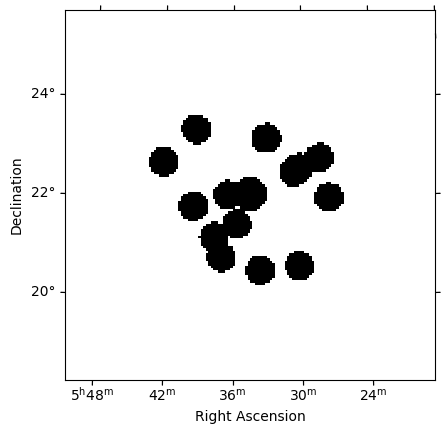

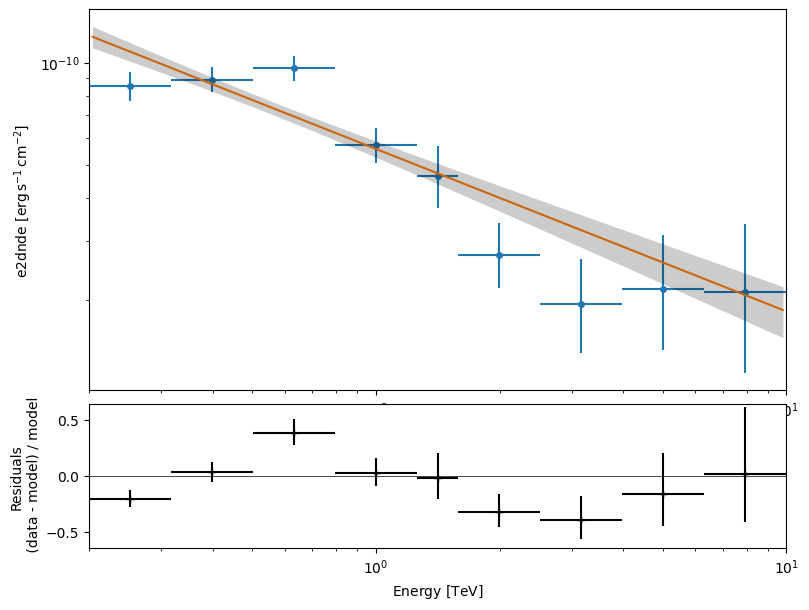

In [12]:
spectral_points, spectral_model, cumulative_time, cumulative_sig = make_spectrum_RE(config)

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

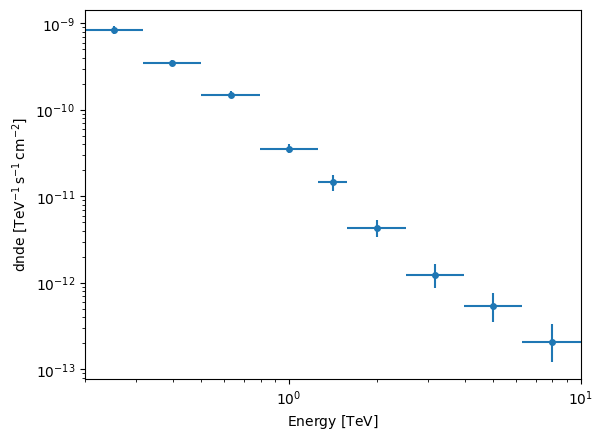

In [13]:
spectral_points.plot(sed_type='dnde')

## Flux/LC analysis

Outputs the integral flux in units of $\textrm{cm}^2 \textrm{s}^{-1}$ (default) or a lightcurve

`get_flux_lc(config,"runwise")` will output a runwise light curve

`get_flux_lc(config,"custom")` will output a custom binned light curve. The binning is defined in `config['lightcurve']['bin_size_min']` as the time per bin in minutes.

In [14]:
flux = get_flux_lc(config,'runwise')

<Axes: xlabel='Time [iso]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

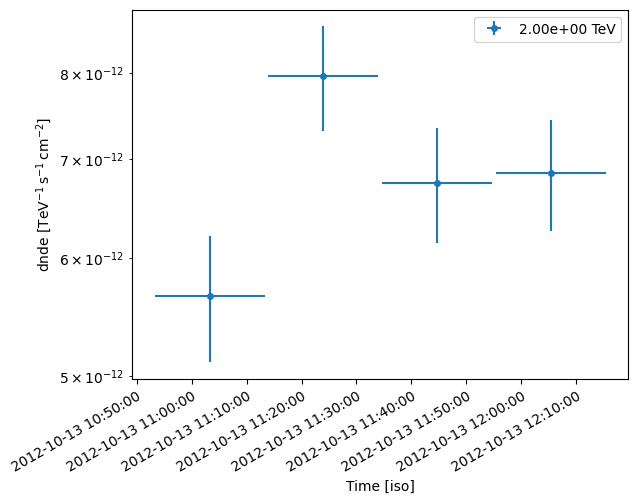

In [15]:
flux.plot()

## RBM analysis

Calculates counts, excess, significance, etc. using RBM normalized by the background files appended to each run.

Parameters are defined in the config file as:
```
sky_map:
    map_deg: 2.5 #map size
    exclusion_regions: [[[85,21],0.3]] #exclusion regions in a list of lists
                                         with individual regions in the format [[RA,DEC], radius]
    theta: 0.08944272 #ON region
    on_exclusion_region: 0.35 #exclusion region around the source in deg (ED default is 0.35 deg)
    ring_rin: "0.6 deg" #inner ring radius (ED default is 0.6 deg)
    ring_width: "0.2 deg" #ring width (ED default is 0.2 deg)
```

In [16]:
config["sky_map"]["map_deg"] = 3.5
config["sky_map"]["on_exclusion_region"] =  0.45

counts, excess, background, alpha, sigma, excess_map, exposure, significance_map, exclusion_mask = rbm_analysis(config)


Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 4 out of 4.
Number of selected observations: 4
Creating reference dataset and makers.
Creating the background Maker.
No background maker set. Check configuration.
Start the data reduction loop.
Computing dataset for observation 64080
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 64081
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 64082
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 64083
Running MapDatasetMaker
Running SafeMaskMaker


## Plot results

Makes RBM maps (significance & excess) and RBM significance distribution. 1D cumulative significance from spectral analysis is also plotted but is not *super* useful.

These plots are saved with the prefix: `config['plot_names']`

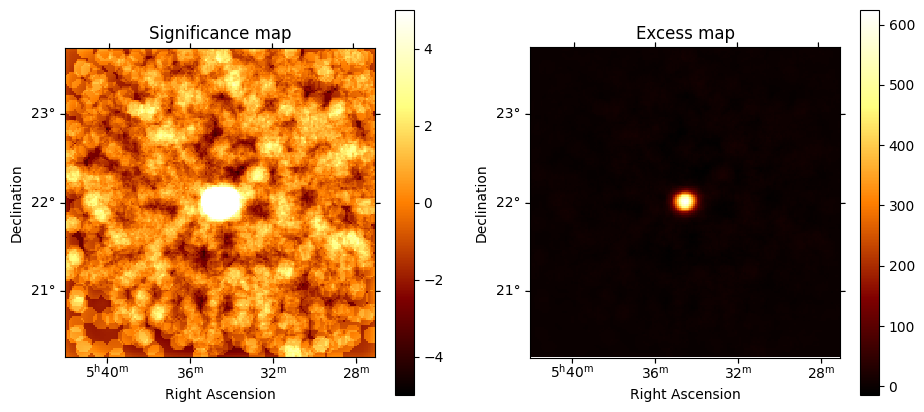

Fit results: mu = -0.09, std = 1.10


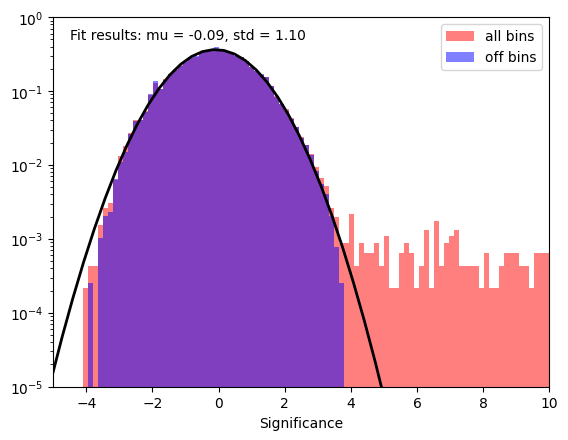

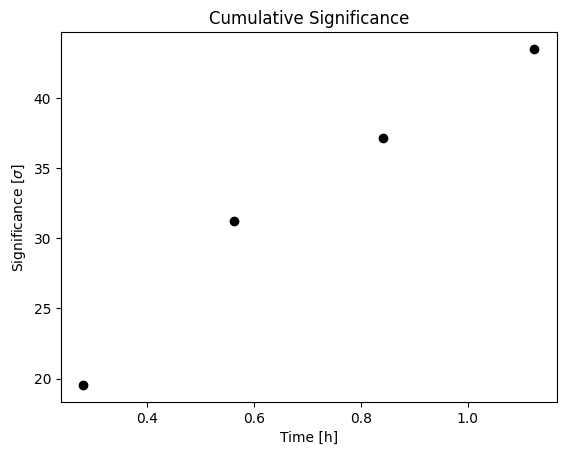

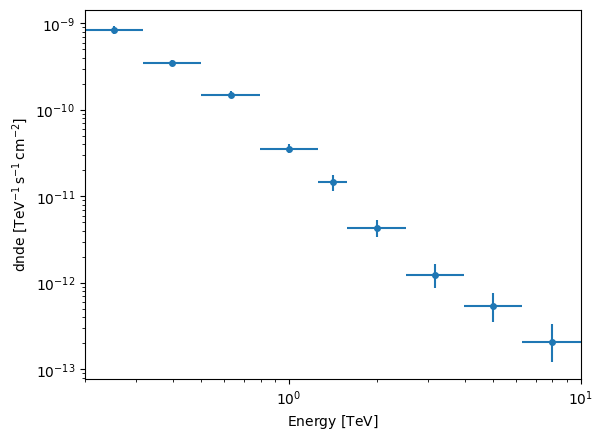

In [17]:
rbm_plots(config, spectral_points, excess_map, significance_map, exclusion_mask, cumulative_sig,cumulative_time)

## Analysis output

Write the analysis output (currently formatted for inputting into the gammapy validation page: https://veritas.sao.arizona.edu/wiki/Gammapy_Validation).

This is saved in yaml format to `config['results_file']`

In [18]:
write_validation_info(config,spectral_model,flux,counts,background,alpha,sigma,exposure)

======== RESULTS ========
source : Crab
gammapy version : 1.1
exposure : 80.13333333333328
on : 642
off : 17
alpha : 1.364e-03
significance : 57.77
flux : 2.03e-10
flux_err : 1.98e-11
flux_UL : False
norm : 3.48e-11
norm_err : 1.93e-12
index : 2.48
index_err : 0.06


ON:614  OFF:18.83 (off 113, alpha=0.1667)
42.38 Sigma  7.427+/-0.31 gammas/min